In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, cross_val_predict

# Regression with ML

As final goodbye (or is it a final FU?) we will use machine learning for a regression task, trying to estimate the mice's running activity from ther phenotype data. Our target will no longer be binary (CD/HFD) or even categorical, but continuous valued.

To help you get started quickly, we have added a few lines of code to create the target vector, and deleted all running-related phenotype measurements from the input, such as night-time running activity.

In [2]:
pheno = pd.read_csv('files/phenotype_cd_hfd.csv', index_col=0)
target = pheno['24hRun_ActivityWheel_[km]']

data = pheno.dropna(axis=1).drop(columns=['strain', '24hRun_ActivityWheel_[km]','DayRun_ActivityWheel_[km]','NightRun_ActivityWheel_[km]', 'Dist_post_[m]', 'Improvement_[meters]', 'Dist_pre_[m]'])
data['diet'] = data['diet'].replace('CD', 0).replace('HFD', 1)

Initialize a regressor, for example `SVR`. You can also use `RandomForestRegressor` or `KNeighborsRegressor`, they all have the same interface, and most code you write using them is interchangeable.

In [3]:
clf = SVR()
clf.fit(data, target) 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

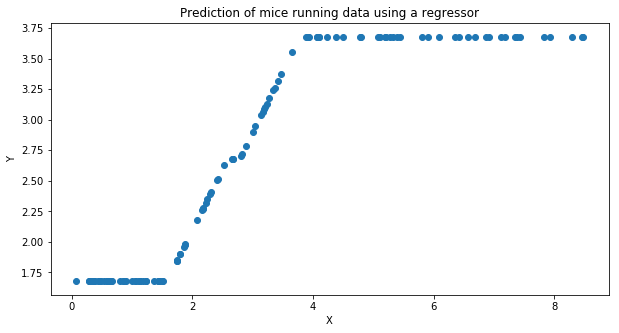

In [4]:
#For not standarized data

clf.predict(data)

fig = plt.subplots(figsize=(10,5))
plot = plt.scatter(x = target,y = clf.predict(data))
plt.title('Prediction of mice running data using a regressor')
plt.xlabel('X', fontsize= 10)
plt.ylabel('Y', fontsize= 10)
plt.show()

This looks really really bad we should definitly normalize the data.

In [5]:
#Normalize data

data_standard = (data - data.mean())/data.std()
clf.fit(data_standard, target) 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Fit and predict all data. Plot the target and predicted vectors against each other using `plt.scatter`.

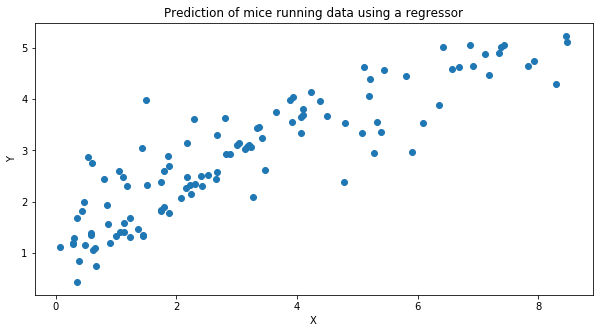

In [6]:
#Again for the normalized data

clf.predict(data_standard)

fig = plt.subplots(figsize=(10,5))
plot = plt.scatter(x = target,y = clf.predict(data_standard))
plt.title('Prediction of mice running data using a regressor')
plt.xlabel('X', fontsize= 10)
plt.ylabel('Y', fontsize= 10)
plt.show()

Perform a cross-validated prediction. "Scoring" as such doesn't make much sense with continuous variables, so just use `cross_val_predict` and present them on a scatter plot against the target values, similar to above. Is it disappointing, satisfactory, or something in between?

Calculate the standard error as a measure of accuracy. It's a one liner: the standard deviation of difference between the predicted and the actual values.

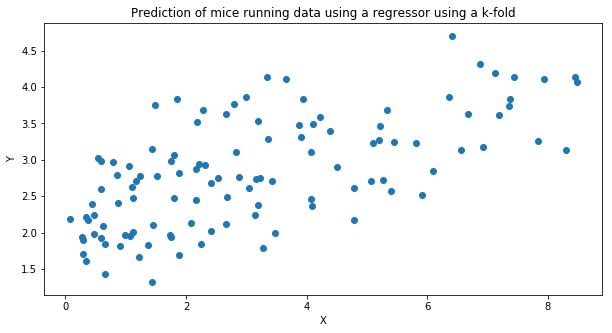

In [7]:
#Again with cross validated data

cv_probs = cross_val_predict(clf, data_standard, target, cv = KFold(3, shuffle=True))

fig = plt.subplots(figsize=(10,5))
plot = plt.scatter(x = target,y = cv_probs)
plt.title('Prediction of mice running data using a regressor using a k-fold')
plt.xlabel('X', fontsize= 10)
plt.ylabel('Y', fontsize= 10)
plt.show()

This is not good. Thus, if we compare this to the plot below, which is randomly generated it is still better.

In [8]:
#Standart error
std_error = (cv_probs - target)
np.sqrt(std_error.dot(std_error)/len(std_error))

1.9102001909218027

What should we compare this performance to? A random predictor could, for example, return a random value from the available target values. Create a scatter plot of what that would be like. Hint: use `np.random.choice`, select a 100 random values twice, and plot them against each other. What is the average standard error for the random predictor?

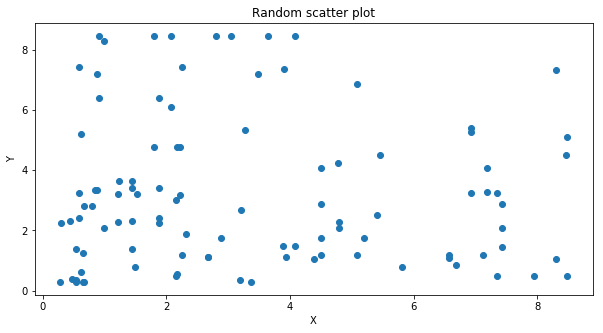

In [9]:
#Random scatterplot

fig = plt.subplots(figsize=(10,5))
plot = plt.scatter(np.random.choice(target,100), np.random.choice(target,100))
plt.title('Random scatter plot')
plt.xlabel('X', fontsize= 10)
plt.ylabel('Y', fontsize= 10)
plt.show()

In [10]:
#Compute standard error for the prediction with the random data

df_random = pd.DataFrame({'x':np.random.choice(target,113), 'y':np.random.choice(target,113)})
cv_probs_random = cross_val_predict(clf, df_random, target, cv = KFold(3, shuffle=True))


std_error = (cv_probs_random - target)
np.sqrt(std_error.dot(std_error)/len(std_error))

#type(np.random.choice(target,100))

2.4100773713632586

If we compute the standart error from this random plot we see that the regressor above still has a better, smaller standart error (1.9114936526901265). So this random plot is actually still worse.

Use a `RandomForestRegressor` to do the task (use at least 100 trees though), and check the most important features. Do they make sense? Take the top 20, and evaluate models that use an increasing amount of them. Did you find a sweet spot?

In [11]:
#Redo previous steps with a randomforest regressor

clf_rf = RandomForestRegressor(n_estimators=100)
clf_rf.fit(data_standard, target) 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

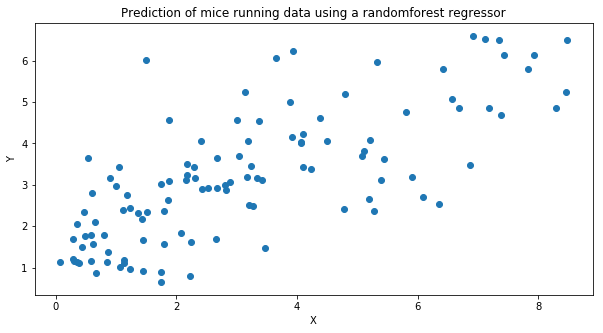

In [12]:
cv_probs_rf = cross_val_predict(clf_rf, data_standard, target, cv = KFold(3, shuffle=True))

fig = plt.subplots(figsize=(10,5))
plt.scatter(x = target,y = cv_probs_rf)
plt.title('Prediction of mice running data using a randomforest regressor')
plt.xlabel('X', fontsize= 10)
plt.ylabel('Y', fontsize= 10)
plt.show()

Seems like the randomforest regressor doesn't perform significantly better ...

In [13]:
#Get features and sort them by the importance
features = pd.DataFrame(clf_rf.feature_importances_, index = data.columns)

features = features.sort_values(0, ascending=False)

In [14]:
#Look at the 20 fetures with the largest importance values
features.nlargest(20, 0, keep='first')

,0
BWLoss_AfterExercise_[%],0.434256
24hXYTot_TSE_[#/hr],0.092132
BodyWeight_Wk8_[g],0.071845
NightXYTot_TSE_[#/hr],0.035691
Gastrocnemius_[%],0.029432
DayXYTot_TSE_[#/hr],0.029224
BodyWeight_postWheel_[g],0.023805
BWGain_8-28Weeks_[%],0.021710
Kidney_[g],0.016361
BodyWeight_Wk16_[g],0.012703


In [15]:
#Run 20 cross validations with different feature sets and compute the standart errors
values = {}
top20 = ['BWLoss_AfterExercise_[%]', '24hXYTot_TSE_[#/hr]', 'BodyWeight_Wk8_[g]', 'NightXYTot_TSE_[#/hr]', 'DayXYTot_TSE_[#/hr]', 'Gastrocnemius_[%]', 'BWGain_8-28Weeks_[%]', 'BWGain_8-28Weeks_[%]', 'Kidney_[g]', 'Glucose0min_OGTT_[mg/dL]', 'BodyWeight_Wk16_[g]', 'Kidney_[%]', 'perirenalWAT_[g]', 'Liver_[%]', 'SystolicBP_NIBP_[mmHg]', 'Decrease_0-3H_[%]', 'DiastolicBP_NIBP_[mmHg]', 'Gastrocnemius_[g]', 'Liver_[g]', '0H_ColdTest_[°C]']
for i in range(1,20):
    cv_pred = cross_val_predict(clf_rf, data_standard.loc[:,top20[:i]], target, cv = KFold(3, shuffle=True))
    print(i, (cv_pred-target).std())
    values[i] = (cv_pred-target).std()

1 1.7924407695735125
2 1.6164830422240435
3 1.4590270736092386
4 1.4594634920886842
5 1.5329543127549783
6 1.4327448901402124
7 1.443335830927496
8 1.5991471015793126
9 1.3563959197559354
10 1.5773089545712384
11 1.4042883886188589
12 1.5401788573236208
13 1.4951265718858942
14 1.4588451032825198
15 1.4092480798700915
16 1.4437892316497118
17 1.5324276874645275
18 1.408657196504031
19 1.5415474829721152


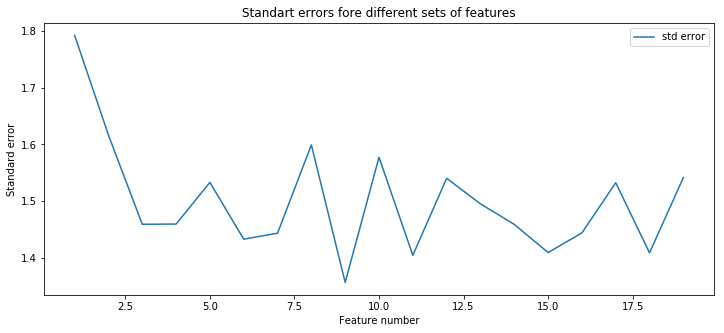

In [16]:
lists = sorted(values.items()) 

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.subplots(figsize=(12,5))
plt.plot(x, y)
plt.xlabel('Feature number')
plt.ylabel('Standard error')
plt.title("Standart errors fore different sets of features")
plt.legend(['std error'])

plt.show()

The plot above shows the standard error on the y-axis against the number of features in the x-axis. A sweet spot would be taking the first six features, since there is the lowest error.